In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder


In [21]:
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersNumber", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [22]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [23]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [24]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [25]:
works = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 0]

temp = works['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
works['unproportionality_coeficient'] = temp[temp.columns[1]]/temp[temp.columns[0]]
works['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]-1.0
works.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [26]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')

workc['unproportionality_coeficient'] = np.zeros([temp.shape[0], 1])
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [27]:
work = pd.concat([works, workc])

del works
del workc


Data ready

<Axes: >

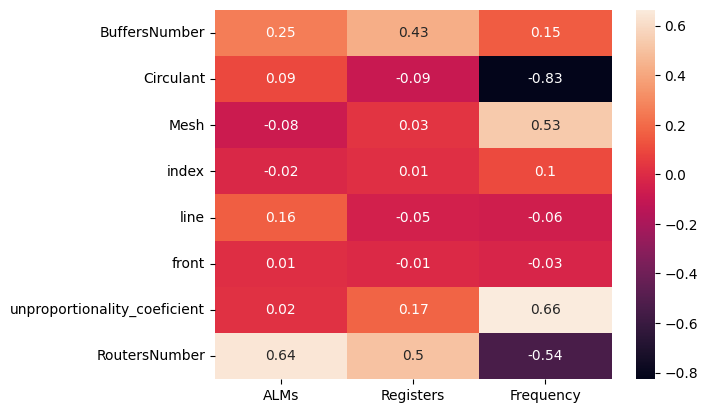

In [29]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "index", "line", "front", "BuffersNumber", "unproportionality_coeficient", "RoutersNumber"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score


In [31]:
X = work.drop(["Registers", "ALMs", "Frequency"] ,axis=1)
y = work[["Registers", "ALMs", "Frequency"]]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [33]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [34]:
model = smf.ols(formula='Registers ~ Mesh + Circulant + index + line + front + RoutersNumber*BuffersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 3.349e+04
Date:                 Сб, 22 мар 2025   Prob (F-statistic):               0.00
Time:                        19:33:50   Log-Likelihood:                -43291.
No. Observations:                4429   AIC:                         8.660e+04
Df Residuals:                    4419   BIC:                         8.667e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [49]:
model = smf.ols(formula='ALMs ~ Mesh + Circulant + index + line + front +  RoutersNumber*BuffersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     9099.
Date:                 Вс, 23 мар 2025   Prob (F-statistic):               0.00
Time:                        01:11:41   Log-Likelihood:                -44441.
No. Observations:                4429   AIC:                         8.890e+04
Df Residuals:                    4419   BIC:                         8.897e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [36]:
model = smf.ols(formula='Frequency ~ Mesh + Circulant + index + line + front +  RoutersNumber*BuffersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4040.
Date:                 Сб, 22 мар 2025   Prob (F-statistic):               0.00
Time:                        19:33:57   Log-Likelihood:                -14598.
No. Observations:                4429   AIC:                         2.922e+04
Df Residuals:                    4419   BIC:                         2.928e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [51]:
lrR = LinearRegression()
lrR.fit(X_train, y_train["Registers"])

lrA = LinearRegression()
lrA.fit(X_train, y_train["ALMs"])

lrF = LinearRegression()
lrF.fit(X_train, y_train["Frequency"])

rP = lrR.predict(X_test)
aP = lrA.predict(X_test)
fP = lrF.predict(X_test)

print("Registers MSE:", root_mean_squared_error(y_test["Registers"], rP), 'R2:', r2_score(y_test["Registers"], rP), '\n', [abs(i) for i in lrR.coef_]/sum([abs(i) for i in lrR.coef_])*100)
print("ALMs MSE:", root_mean_squared_error(y_test["ALMs"], aP), 'R2:', r2_score(y_test["ALMs"], aP), '\n',[abs(i) for i in lrA.coef_]/sum([abs(i) for i in lrA.coef_])*100)
print("Frequency MSE:", root_mean_squared_error(y_test["Frequency"], fP), 'R2:', r2_score(y_test["Frequency"], fP), '\n', [abs(i) for i in lrF.coef_]/sum([abs(i) for i in lrF.coef_])*100)


Registers MSE: 16390.772961807987 R2: 0.792512119302724 
 [ 7.78916094  7.9514625  32.68877846  5.84272492 19.8583517   4.82537334
 15.36083159  5.68331655]
ALMs MSE: 10666.48716283682 R2: 0.8124855116203299 
 [ 4.66452975  4.56646601 21.54027306 15.02252186 39.2843634   6.25574369
  4.46586437  4.20023786]
Frequency MSE: 6.181073444290395 R2: 0.9065326808841966 
 [ 1.53165723 77.41587395  8.70396633  6.53730203  1.49877291  2.72216175
  0.91451301  0.67575279]


/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.w